In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import string
import re
import nltk
from matplotlib import pyplot as plt
import seaborn as sn

In [2]:
#load word vectorization model
import gensim.downloader
print(list(gensim.downloader.info()["models"].keys()))
word2vec = gensim.downloader.load("glove-wiki-gigaword-50")

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [3]:
# read flight data 
df = pd.read_csv("data/disaster_response_messages_training.csv")


train_text = df["message"]
wordCountPreFilter = len(train_text)


train_label = df[df.columns[7:]]

C:\Users\Noeth\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# maximal length of included words (also determines the amount of zero padding)
MAXLEN = 40

# Preprocessing functions
def remove_punctuation(text):
    return "".join([i for i in text if i not in string.punctuation])

def tokenitzation(text):
    return re.split("\W+", text)

def remove_empty(text):
    return [word for word in text if word]

stopwords = nltk.corpus.stopwords.words("english")
def remove_stopwords(text):
    return [word for word in text if word not in stopwords]

def vectorization(text):
    res = []
    for word in text:
        try:
            res.append(word2vec[word])
        except:
            res.append(np.zeros(50))
    # zero padding
    for _ in range(len(res), MAXLEN):
        res.append(np.zeros(50))
    return np.array(res)

def preprocess(text):
    # remove punctuation
    text = remove_punctuation(text)
    # remove uppercase
    text = text.lower()
    # tokenize
    text = tokenitzation(text)
    # remove empty strings
    text = remove_empty(text)
    #remove stopwords
    text = remove_stopwords(text)
    return text
    
# filtering unwanted words
def filter_words(texts, labels):
    filtered_texts = []
    filtered_labels = []
    for i,text in enumerate(texts):
        # add text and label to the arrays 
        if len(text) > 0 and len(text) < MAXLEN:
            filtered_texts.append(text)
            filtered_labels.append(np.array(labels.iloc[[i]])[0])
            
    return filtered_texts, filtered_labels


#prepare data with one function(mostly for test and validation set, since I want to make plots 
# with the training set)
def prepare_data(text, labels):
    text = text.apply(preprocess)
    text, labels = filter_words(text, labels)
    text = [vectorization(sen) for sen in text]
    return np.array(text), np.array(labels)

min amount of words: 1
max amount of words: 39
median amount of words: 12.0
sentences: 20775
filtered words: 271


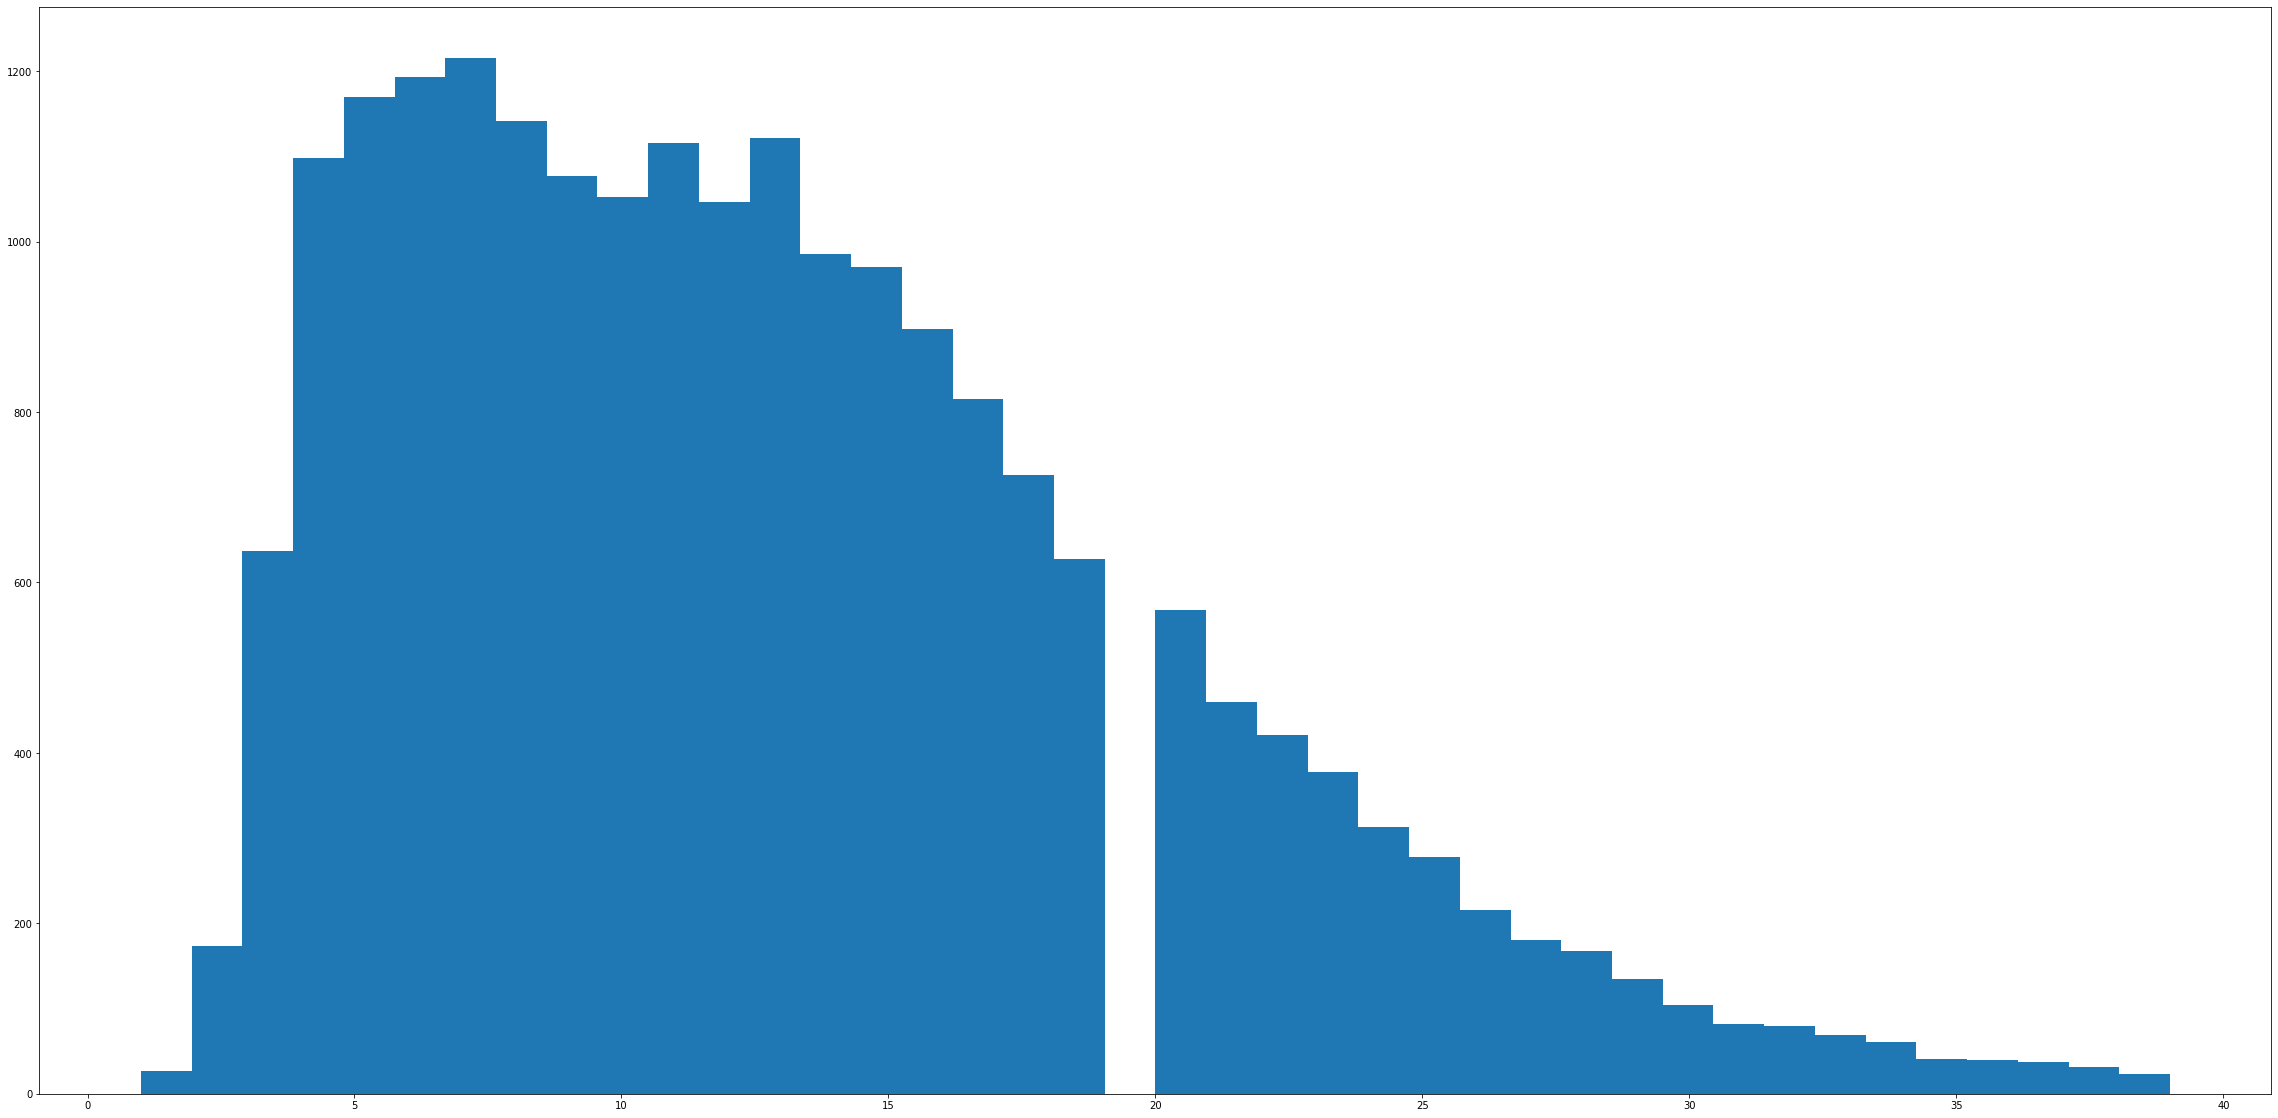

In [5]:
train_set = train_text.apply(preprocess)
train_set, train_labels_set = filter_words(train_set, train_label)

train_labels_set = np.array(train_labels_set)

def median(data):
    data.sort()
    mid = len(data) // 2
    return (data[mid] + data[~mid]) / 2

# visualize dataset
word_count = [len(sen) for sen in train_set]
print(f"min amount of words: {min(word_count)}\nmax amount of words: {max(word_count)}")
print(f"median amount of words: {median(word_count)}\nsentences: {len(word_count)}")
print(f"filtered words: {wordCountPreFilter - len(train_set)}")
plt.figure(figsize = (40,20))
plt.hist(word_count, bins = 40)

train_set = np.array([vectorization(sen) for sen in train_set])

In [11]:
# prepare validation data
valSet = pd.read_csv("data/disaster_response_messages_validation.csv")
valText = valSet["message"]
valLen = len(valSet["message"])
valLabels =  valSet[valSet.columns[7:]]
valText, valLabels = prepare_data(valText, valLabels)
print(f"filtered words: {valLen - len(valText)}")


def multi_label_accuracy(pred, true):
    predLs, trueLs = list(pred), list(true)
    return sum([predVal == trueLs[i] for i,predVal in enumerate(list(predLs))]) / len(predLs)

filtered words: 36


In [12]:
model = keras.Sequential([
    layers.LSTM(64, input_shape = (MAXLEN,50)),
    layers.Dense(32),
    layers.Dense(16),
    layers.Dense(35, activation = "sigmoid")
])


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 35)                595       
Total params: 32,643
Trainable params: 32,643
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["binary_accuracy"])

model.fit(train_set, train_labels_set, 
          epochs = 8, batch_size = 16,
          validation_data = (valText, valLabels))

Epoch 1/8
1299/1299 [==============================] - 32s 24ms/step - loss: 0.1545 - binary_accuracy: 0.9476 - val_loss: 0.1509 - val_binary_accuracy: 0.9491
Epoch 2/8
1299/1299 [==============================] - 39s 30ms/step - loss: 0.1481 - binary_accuracy: 0.9497 - val_loss: 0.1469 - val_binary_accuracy: 0.9500
Epoch 3/8
1299/1299 [==============================] - 32s 25ms/step - loss: 0.1428 - binary_accuracy: 0.9514 - val_loss: 0.1461 - val_binary_accuracy: 0.9506
Epoch 4/8
1299/1299 [==============================] - 28s 21ms/step - loss: 0.1393 - binary_accuracy: 0.9527 - val_loss: 0.1415 - val_binary_accuracy: 0.9522
Epoch 5/8
1299/1299 [==============================] - 33s 25ms/step - loss: 0.1359 - binary_accuracy: 0.9536 - val_loss: 0.1425 - val_binary_accuracy: 0.9523
Epoch 6/8
1299/1299 [==============================] - 26s 20ms/step - loss: 0.1332 - binary_accuracy: 0.9547 - val_loss: 0.1395 - val_binary_accuracy: 0.9528
Epoch 7/8
1299/1299 [=========================

In [16]:
#prepare test data
testSet = pd.read_csv("data/disaster_response_messages_test.csv")
testText = testSet["message"]
testLabel = testSet[testSet.columns[7:]]
testText, testLabel = prepare_data(testText, testLabel)

In [17]:
model.evaluate(testText, testLabel)

82/82 [==============================] - 1s 6ms/step - loss: 0.1433 - binary_accuracy: 0.9590


[0.14333626627922058, 0.959013044834137]

In [23]:
prediction = model.predict(np.expand_dims(testText[3], axis = 0))
def round_prediction(pred):
    return pred > 0.5

prediction = [round_prediction(pred) for pred in prediction]
        

    
res = [round_prediction(x) for x in prediction[0]]
print(multi_label_accuracy(prediction[0], testLabel[3]))

0.8857142857142857
